In [1]:
import transformers
from transformers import AutoTokenizer,BitsAndBytesConfig,AutoModelForSeq2SeqLM,DataCollatorForLanguageModeling
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import torch
import pandas as pd

In [2]:
model_name = "Salesforce/codet5p-770m"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name,device_map="auto",trust_remote_code=False,revision="main",quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name,use_fast=True)

In [3]:
inputs = tokenizer.encode("def print_hello_world():<extra_id_0>", return_tensors="pt").to("cuda:0")
outputs = model.generate(inputs, max_length=10)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


    print "Hello World!"



In [3]:
model.train()
model = prepare_model_for_kbit_training(model)

In [4]:
# LoRA config
config = LoraConfig(
    r=8,
    lora_alpha=64,
    target_modules="all-linear", # this tells what thing to update in the model, here we update all linear layers
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ2SEQ_LM" # this tells the task type of the model input is a sequence and output is a sequence
)

# LoRA trainable version of model
model = get_peft_model(model, config)

# trainable parameter count
model.print_trainable_parameters()

trainable params: 8,650,752 || all params: 746,290,176 || trainable%: 1.1592


here we get the model we need to train

#

#

# now dataset prepare

In [5]:
special_tokens = ['[U_VARIABLE]','[U_CLASS]','[U_METHOD]','[R]','[S_CLASS]', '[S_PACKAGE]','[S_METHOD]'
]
tokenizer.add_tokens(special_tokens) # we add this things in the tokens as we used them for annotation
model.resize_token_embeddings(len(tokenizer)) # we add some tokens so we need to rsize the token emnedding


Embedding(32107, 1024)

In [6]:
# Load data from text files
with open('/home/arya/my_python/my_torch/cq/noun_data/train_processed.code', 'r') as f:
    annotated_code = f.readlines()

with open('/home/arya/my_python/my_torch/cq/noun_data/clean_train.comment', 'r') as f:
    descriptions = f.readlines()

# Ensure that all lists have the same length
assert len(annotated_code) == len(descriptions)

<Axes: ylabel='Frequency'>

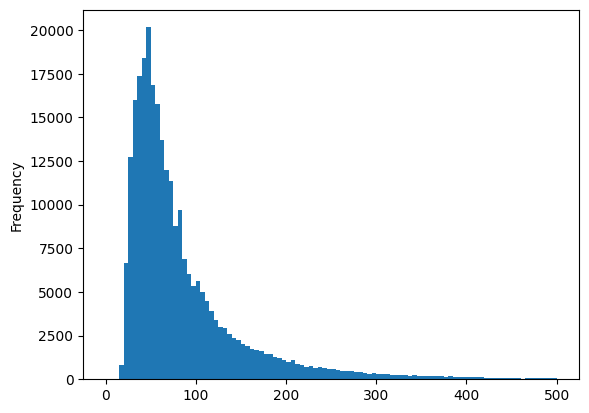

In [8]:
# make a plot of the length of the descriptions and max x axis to 500
pd.Series([len(description) for description in descriptions]).plot.hist(bins=100, range=[0, 500])

<Axes: ylabel='Frequency'>

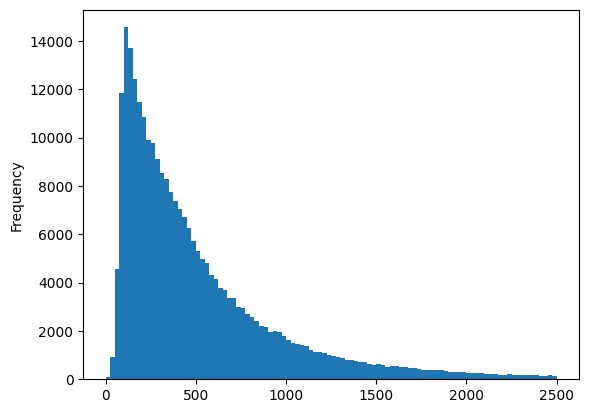

In [9]:
#  make a plot of the length of the antaed code
pd.Series([len(code) for code in annotated_code]).plot.hist(bins=100, range=[0, 2500])

In [7]:
data = {
    "annotated_code": [line.strip() for line in annotated_code],
    "description": [line.strip() for line in descriptions]
}
df = pd.DataFrame(data)

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

In [8]:
del df
del data
del annotated_code
del descriptions

In [9]:
# Function to tokenize the dataset

def tokenize_function(examples):
    inputs = tokenizer(examples['annotated_code'], padding="max_length", truncation=True, max_length=512,return_tensors="pt")
    targets = tokenizer(examples['description'], padding="max_length", truncation=True, max_length=250,return_tensors="pt")
    inputs["labels"] = targets["input_ids"]
    return inputs

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True,remove_columns=["annotated_code", "description"])

Map:   0%|          | 0/269270 [00:00<?, ? examples/s]

In [13]:
print(tokenized_datasets)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 269270
})


In [14]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.1)
del tokenized_datasets
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
del train_test_split


In [15]:
# setting pad token
tokenizer.pad_token = tokenizer.eos_token
# data collator
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# training args

In [16]:
training_args = transformers.TrainingArguments(
    output_dir= "shawgpt-ft",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    fp16=True,
    optim="paged_adamw_8bit",

)

/home/arya/my_python/my_torch/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

base_model.model.shared.weight False
base_model.model.encoder.block.0.layer.0.SelfAttention.q.base_layer.weight False
base_model.model.encoder.block.0.layer.0.SelfAttention.q.lora_A.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.q.lora_B.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.k.base_layer.weight False
base_model.model.encoder.block.0.layer.0.SelfAttention.k.lora_A.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.k.lora_B.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.v.base_layer.weight False
base_model.model.encoder.block.0.layer.0.SelfAttention.v.lora_A.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.v.lora_B.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttention.o.base_layer.weight False
base_model.model.encoder.block.0.layer.0.SelfAttention.o.lora_A.default.weight True
base_model.model.encoder.block.0.layer.0.SelfAttent

In [17]:
# configure trainer
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=data_collator
)

for param in model.parameters():
    param.requires_grad = True

# train model
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# renable warnings
model.config.use_cache = True

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chablings2287 (chablings). Use `wandb login --relogin` to force relogin


/home/arya/my_python/my_torch/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/arya/my_python/my_torch/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn